# JAX Introduction

Companion code for this article: https://iaml.it/blog/jax-intro/

## Install

In [ ]:
# If not working, check here for the latest installation instructions --> https://jax.readthedocs.io/en/latest/
!pip install --upgrade https://storage.googleapis.com/jax-wheels/cuda92/jaxlib-0.1.4-py3-none-linux_x86_64.whl
!pip install --upgrade jax

    100% |████████████████████████████████| 28.3MB 1.3MB/s 
    100% |████████████████████████████████| 153kB 13.4MB/s 
    100% |████████████████████████████████| 61kB 23.5MB/s 
  Running setup.py bdist_wheel for jax ... - \ done
  Stored in directory: /root/.cache/pip/wheels/82/f9/16/df8fff7842b4c5d2de204afeb0447e5f172c01e4621d149594
  Running setup.py bdist_wheel for opt-einsum ... - done
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built jax opt-einsum


## Basic 1 - NumPy acceleration

In [ ]:
# Let's try a simple computation on NumPy
import numpy as np

x = np.ones((5000, 5000))
y = np.arange(5000)

%timeit -n10 -r3 np.sin(x) + np.cos(y)

10 loops, best of 3: 472 ms per loop


In [ ]:
# Same on JAX
import jax.numpy as np

x = np.ones((5000, 5000))
y = np.arange(5000)

%timeit -n10 -r3 np.sin(x) + np.cos(y)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'lapack' does not match runtime version 3.6
  return f(*args, **kwds)


10 loops, best of 3: 30.5 ms per loop


In [ ]:
def fn(x, y):
  z = np.sin(x)
  w = np.cos(y)
  return z + w

%timeit -n10 -r3 fn(x, y)

10 loops, best of 3: 30.2 ms per loop


In [ ]:
from jax import jit

@jit
def fn(x, y):
  z = np.sin(x)
  w = np.cos(y)
  return z + w

%timeit -n10 -r3 fn(x, y)

10 loops, best of 3: 20.3 ms per loop


In [ ]:
# Alternative

def fn(x, y):
  z = np.sin(x)
  w = np.cos(y)
  return z + w

fn = jit(fn)

%timeit -n10 -r3 fn(x, y)

10 loops, best of 3: 20.2 ms per loop


## Medium 1 - Gradient computation

In [ ]:
@jit
def simple_fun(x):
  return np.sin(x) / x

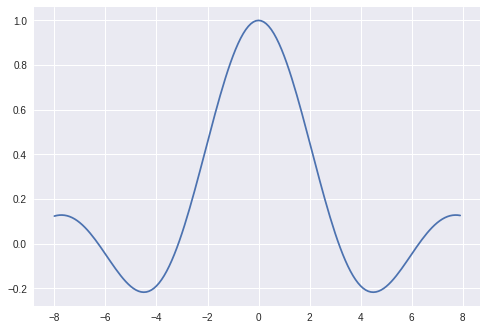

In [ ]:
import matplotlib.pyplot as plt
x_range = np.arange(-8.0, 8.0, 0.1) # Bug: https://github.com/google/jax/issues/145
plt.plot(x_range, simple_fun(x_range))
plt.show()

In [ ]:
from jax import grad
grad_simple_fun = grad(simple_fun)

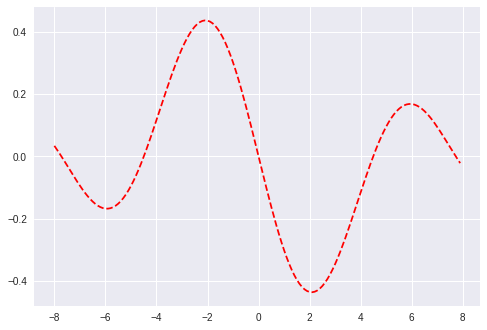

In [ ]:
plt.plot(x_range, [grad_simple_fun(xi) for xi in x_range], '--r')
plt.show()

In [ ]:
grad_grad_simple_fun = grad(grad(simple_fun))

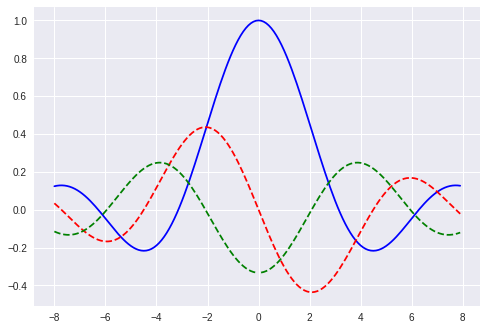

In [ ]:
plt.plot(x_range, simple_fun(x_range), 'b')
plt.plot(x_range, [grad_simple_fun(xi) for xi in x_range], '--r')
plt.plot(x_range, [grad_grad_simple_fun(xi) for xi in x_range], '--g')
plt.show()

## Advanced 1: vmap

In [ ]:
from jax import vmap
grad_vect_simple_fun = vmap(grad_simple_fun)(x_range)

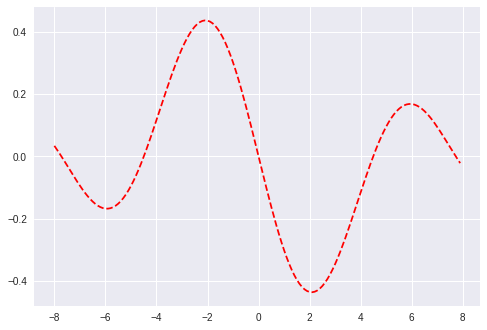

In [ ]:
plt.plot(x_range, grad_vect_simple_fun, '--r')

In [ ]:
%timeit -n10 -r3 jit(lambda: [grad_simple_fun(xi) for xi in x_range])()
%timeit -n10 -r3 vmap(grad_simple_fun)(x_range)

10 loops, best of 3: 420 ms per loop
10 loops, best of 3: 4.68 ms per loop


## Basic 2 - Pseudorandom number generation

In [ ]:
from jax import random

# Generate key
key = random.PRNGKey(0)

# Need key for pseudorandom functions
print(random.normal(key, shape=(3,)))
print(random.normal(key, shape=(3,)))

[ 1.8160863  -0.48262316  0.33988908]
[ 1.8160863  -0.48262316  0.33988908]


In [ ]:
# For successive calls, need to split the key
key, new_key = random.split(key)

print(random.normal(key, shape=(3,)))
print(random.normal(new_key, shape=(3,)))

[ 0.13893168  0.509335   -0.53116107]
[ 1.1378784  -1.2209548  -0.59153634]


## Some neural networks!

In [ ]:
from sklearn import datasets, model_selection, preprocessing
data = datasets.load_iris()
y = preprocessing.OneHotEncoder(sparse=False, categories='auto').fit_transform(data['target'].reshape(-1, 1))
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(data['data'], y)

In [ ]:
# Define the neural network
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax

net_init, net_apply = stax.serial(
    Dense(10), Relu,
    Dense(3), LogSoftmax,
)

In [ ]:
out_shape, net_params = net_init((-1, 4))

In [ ]:
print(net_params)

[(array([[-0.14994451, -0.30441993,  0.14186014,  0.7623606 ,  0.37557867,
        -0.02608331, -0.71927243,  0.32833135, -0.7756463 , -0.2608348 ],
       [-0.05847525,  0.20961495,  0.39558828, -0.05252603, -0.08971493,
         0.51805866,  0.60114443, -0.59093916,  0.00298999, -0.3430339 ],
       [ 1.1677904 ,  0.21431684,  0.13567886, -0.04100764,  0.9316747 ,
         1.0500773 , -0.95003843,  0.61863554,  0.37563547, -0.5930566 ],
       [-0.61191237, -0.40891197, -0.11991894, -0.4528012 ,  0.37535977,
         0.33654782,  0.74536103,  0.32494336, -0.6906026 , -0.06419151]],
      dtype=float32), array([-0.01415817,  0.01880777, -0.01178568,  0.00875717,  0.00063137,
        0.01223112, -0.00755806, -0.00355607, -0.00992471,  0.00957811],
      dtype=float32)), (), (array([[ 0.34959432,  0.8868258 ,  0.7674316 ],
       [-0.574943  , -1.0832853 , -0.07267767],
       [ 1.1170574 , -0.03164655,  0.3035556 ],
       [ 0.05550315, -0.55876434, -0.09560312],
       [ 0.13351656, -

In [ ]:
print(net_apply(net_params, Xtrain))

[[-3.19538116e-02 -1.84762192e+01 -3.45941210e+00]
 [-2.27580070e-02 -1.19376688e+01 -3.79449344e+00]
 [-3.74011993e-02 -1.11317797e+01 -3.30508924e+00]
 [-1.65901184e-02 -2.36853161e+01 -4.10721016e+00]
 [-3.82270813e-02 -1.10324955e+01 -3.28369308e+00]
 [-3.06277275e-02 -1.18963928e+01 -3.50135350e+00]
 [-1.95884705e-02 -2.22814007e+01 -3.94260406e+00]
 [-1.87468529e-02 -1.15998802e+01 -3.98658538e+00]
 [-4.77309227e-02 -1.01623087e+01 -3.06677437e+00]
 [-1.84679031e-02 -2.32490540e+01 -4.00095367e+00]
 [-1.49831772e-02 -2.37728767e+01 -4.20829391e+00]
 [-1.75571442e-02 -2.15150299e+01 -4.05107021e+00]
 [-2.97203064e-02 -2.04889164e+01 -3.53075981e+00]
 [-1.15394592e-02 -2.83169918e+01 -4.46767044e+00]
 [-4.53863144e-02 -1.58993511e+01 -3.11514807e+00]
 [-3.96552086e-02 -9.98019028e+00 -3.24848342e+00]
 [-1.75261497e-02 -1.19071865e+01 -4.05319548e+00]
 [-3.79548073e-02 -1.12043161e+01 -3.29063749e+00]
 [-2.09035873e-02 -1.99774437e+01 -3.87828064e+00]
 [-1.21345520e-02 -2.90250950e+

In [ ]:
def loss(params):
  predictions = net_apply(params, Xtrain)
  return - np.mean(ytrain * predictions)

In [ ]:
from jax.experimental import minmax
opt_init, opt_update = minmax.adam(step_size=0.01)

In [ ]:
from jax import value_and_grad
@jit
def step(i, opt_state):
  params = minmax.get_params(opt_state)
  l, g = value_and_grad(loss)(params)
  return opt_update(i, g, opt_state), l

In [ ]:
import numpy as onp

opt_state = opt_init(net_params)
l_history = onp.zeros(100)
for i in range(100):
  opt_state, l_history[i] = step(i, opt_state)
net_params = minmax.get_params(opt_state)

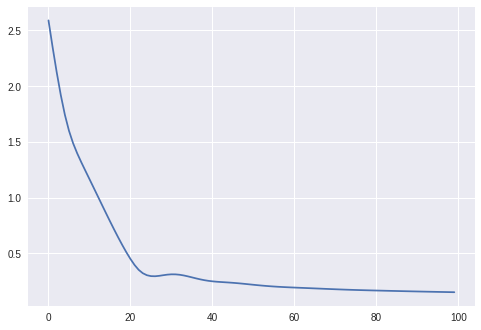

In [ ]:
import matplotlib.pyplot as plt
plt.plot(l_history)
plt.show()

In [ ]:
ytrue = np.argmax(ytest, axis=1)
ypred = np.argmax(net_apply(net_params, Xtest), axis=1)
print(np.mean(ytrue == ypred))

0.94736844
